<img src="../images/logos/arm_logo.png" width=500 alt="ARM Logo"></img>

# Py-ART Corrections
---

## Overview
   
Within this notebook, we will cover:

1. Intro to radar aliasing.
1. Calculation of velocity texture using Py-ART
1. Dealiasing the velocity field

## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Py-ART Basics](pyart-basics) | Helpful | Basic features |
| [Matplotlib Basics](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html) | Helpful | Basic plotting |
| [NumPy Basics](https://foundations.projectpythia.org/core/numpy/numpy-basics.html) | Helpful | Basic arrays |

- **Time to learn**: 30 minutes
---

## Imports

In [1]:
import os
import warnings

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np


import pyart
from pyart.testing import get_test_data

warnings.filterwarnings('ignore')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## Read in the Data and Plot the Data

### Read in a sample file from the Southern Great Plains (SGP) Site
Our data is formatted as an *`mdv`* file, which is the abbreviation for Meteorological Data Volume, a data format developed by the National Center for Atmospheric Research in the early 1990s.

In [3]:
file = get_test_data('110635.mdv')
radar = pyart.io.read(file)

### Plot a quick-look of reflectivity and velocity
We can start by taking a quick look at the reflectivity and velocity fields. Notice how the velocity field is **rather messy**, indicated by the speckles and high/low values directly next to each other

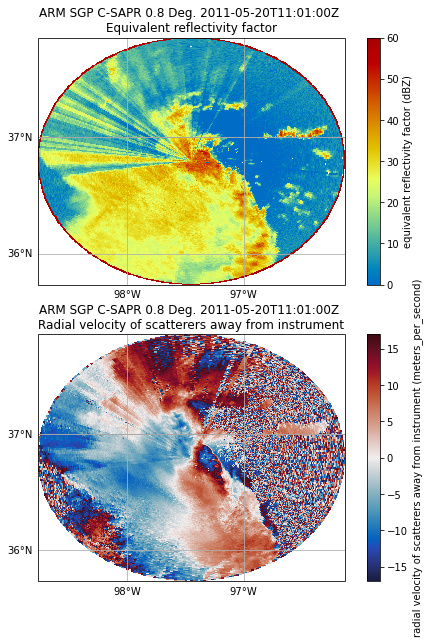

In [48]:
fig = plt.figure(figsize=[8, 10])
ax = plt.subplot(211, projection=ccrs.PlateCarree())
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map('reflectivity',
                     ax=ax,
                     sweep=0,
                     resolution='50m',
                     vmin=0,
                     vmax=60, 
                     projection=ccrs.PlateCarree(),
                     cmap='pyart_HomeyerRainbow')

ax2 = plt.subplot(2,1,2,projection=ccrs.PlateCarree())
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map('velocity',
                     ax=ax2,
                     sweep=0,
                     resolution='50m',
                     vmin=-17,
                     vmax=17, 
                     projection=ccrs.PlateCarree(),
                     cmap='pyart_balance')
plt.show()

## Dealiasing our Velocity

### An Overview of Aliasing

The radial velocity measured by the radar is mesasured by detecing the phase shift between the transmitted pulse and the pulse recieved by the radar. However, using this methodology, it is only possible to detect phase shifts within $\pm 2\pi$ due to the periodicity of the transmitted wave. Therefore, for example, a phase shift of $3\pi$ would erroneously be detected as a phase shift of $-\pi$ and give an incorrect value of velocity when retrieved by the radar. This phenomena is called aliasing. The maximium unambious velocity that can be detected by the radar before aliasing occurs is called the Nyquist velocity.

In the next example, you will see an example of aliasing occurring, where the values of +15 m/s abruptly transition into a region of -15 m/s, with -5 m/s in the middle of the region around 37 N, 97 W.

### Calculate Velocity Texture

First, for dealiasing to work efficiently, we need to use a GateFilter. Notice that, this time, the data shown does not give us a nice gate_id. This is what raw data looks like, and we need to do some preprocessing on the data to remove noise and clutter. Thankfully, Py-ART gives us the capability to do this. As a simple filter in this example, we will first calculate the velocity texture using Py-ART's [`calculate_velocity_texture`](https://arm-doe.github.io/pyart/API/generated/pyart.retrieve.calculate_velocity_texture.html) function. The velocity texture is the standard deviation of velocity surrounding a gate. This will be higher in the presence of noise.

Let's investigate this function first...

In [19]:
pyart.retrieve.calculate_velocity_texture?

Signature:
pyart.retrieve.calculate_velocity_texture(
    radar,
    vel_field=None,
    wind_size=4,
    nyq=None,
    check_nyq_uniform=True,
)
Docstring:
Derive the texture of the velocity field.

Parameters
----------
radar: Radar
    Radar object from which velocity texture field will be made.
vel_field : str, optional
    Name of the velocity field. A value of None will force Py-ART to
    automatically determine the name of the velocity field.
wind_size : int, optional
    The size of the window to calculate texture from. The window is
    defined to be a square of size wind_size by wind_size.
nyq : float, optional
    The nyquist velocity of the radar. A value of None will force Py-ART
    to try and determine this automatically.
check_nyquist_uniform : bool, optional
    True to check if the Nyquist velocities are uniform for all rays
    within a sweep, False will skip this check. This parameter is ignored
    when the nyq parameter is not None.

Returns
-------
vel_dict: dic

### Determining the Right Parameters
You'll notice that we need:
- Our radar object
- The name of our velocity field
- The number of gates within our window to use to calculate the texture
- The nyquist velocity

We can retrieve the nyquest velocity from our instrument parameters fortunately - using the following syntax!

In [24]:
nyquist_velocity = radar.instrument_parameters["nyquist_velocity"]["data"]
nyquist_velocity

array([16.52468, 16.52468, 16.52468, ..., 16.52468, 16.52468, 16.52468],
      dtype=float32)

While the nyquist velocity is stored as an array, we see that these are all the same value...

In [54]:
np.unique(nyquist_velocity)

array([16.52468], dtype=float32)

Let's save this single value to a float to use later...

In [55]:
nyquist_value = np.unique(nyquist_velocity)[0]

### Calculate Velocity Texture and Filter our Data
Now that we have an ide?a of which parameters to pass in, let's calculate velocity texture!

In [56]:
vel_texture = pyart.retrieve.calculate_velocity_texture(radar,
                                                        vel_field='velocity',
                                                        nyq=nyquist_value)
vel_texture

{'units': 'meters_per_second',
 'standard_name': 'texture_of_radial_velocity_of_scatters_away_from_instrument',
 'long_name': 'Doppler velocity texture',
 'coordinates': 'elevation azimuth range',
 'data': array([[7.51300375, 6.08543553, 5.92741611, ..., 5.84680145, 5.87766469,
         5.8796826 ],
        [7.51300375, 5.92741611, 5.52273606, ..., 5.84680145, 5.87766469,
         5.8796826 ],
        [6.31927866, 5.92741611, 5.52273606, ..., 5.94545992, 5.98767892,
         5.99355426],
        ...,
        [7.28154521, 7.17077244, 5.99292346, ..., 5.69339285, 5.64166993,
         5.64166993],
        [7.77209257, 7.77209257, 5.95091982, ..., 5.48500863, 5.42860475,
         5.42860475],
        [7.99320448, 7.99320448, 5.95091982, ..., 2.32524392, 2.33743921,
         2.3474649 ]])}

The `pyart.retrieve.calculate_velocity_texture` function results in a data dictionary, including the actual data, as well as metadata. We can add this to our `radar` object, by using the `radar.add_field` method, passing the name of our new field (`"texture"`), the data dictionary (`vel_texture`), and a clarification that we want to replace the existing velocity texture field if it already exists in our radar object (`replace_existing=True`)

In [57]:
radar.add_field('texture', vel_texture, replace_existing=True)

#### Plot our Velocity Texture Field

Now that we have our velocity texture field added to our radar object, let's plot it!

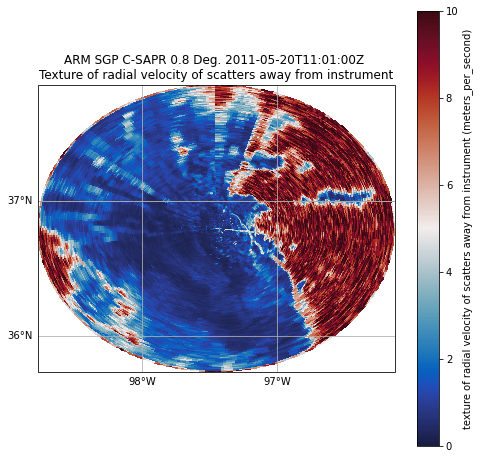

In [76]:
fig = plt.figure(figsize=[8, 8])
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map('texture',
                     sweep=0,
                     resolution='50m',
                     vmin=0,
                     vmax=10, 
                     projection=ccrs.PlateCarree(),
                     cmap='pyart_balance')
plt.show()

#### Determine a Suitable Velocity Texture Threshold

Plot a histogram of velocity texture to get a better idea of what values correspond to hydrometeors and what values of texture correspond to artifacts.

In the below example, a threshold of 3 would eliminate most of the peak corresponding to noise around 6 while preserving most of the values in the peak of ~0.5 corresponding to hydrometeors.

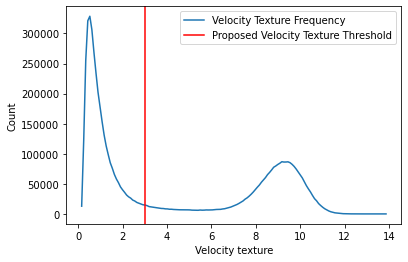

In [59]:
hist, bins = np.histogram(radar.fields['texture']['data'],
                          bins=150)
bins = (bins[1:]+bins[:-1])/2.0

plt.plot(bins,
         hist,
         label='Velocity Texture Frequency')
plt.axvline(3,
            color='r',
            label='Proposed Velocity Texture Threshold')

plt.xlabel('Velocity texture')
plt.ylabel('Count')
plt.legend()

#### Setup a Gatefilter Object and Apply our Threshold

Now we can set up our GateFilter ([`pyart.filters.GateFilter`](https://arm-doe.github.io/pyart/API/generated/pyart.filters.GateFilter.html#pyart.filters.GateFilter)), which allows us to easily apply masks and filters to our radar object.

In [60]:
gatefilter = pyart.filters.GateFilter(radar)
gatefilter

We discovered that a velocity texture threshold of **only including values below 3** would be suitable for this dataset, we use the `.exclude_above` method, specifying we want to exclude `texture` values above 3.

In [61]:
gatefilter.exclude_above('texture', 3)

#### Plot our Filtered Data

Now that we have created a gatefilter, filtering our data using the velocity texture, let's plot our data!

We need to pass our gatefilter to the `plot_ppi_map` to apply it to our plot.

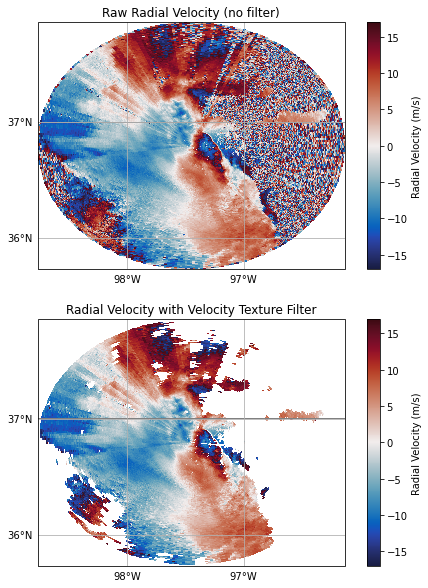

In [74]:
# Plot our Unfiltered Data
fig = plt.figure(figsize=[8, 10])
ax = plt.subplot(211, projection=ccrs.PlateCarree())
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map('velocity',
                     title='Raw Radial Velocity (no filter)',
                     ax=ax,
                     sweep=0,
                     resolution='50m',
                     vmin=-17,
                     vmax=17,
                     projection=ccrs.PlateCarree(),
                     colorbar_label='Radial Velocity (m/s)',
                     cmap='pyart_balance')

ax2 = plt.subplot(2,1,2,projection=ccrs.PlateCarree())

# Plot our filtered data
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map('velocity',
                     title='Radial Velocity with Velocity Texture Filter',
                     ax=ax2,
                     sweep=0,
                     resolution='50m',
                     vmin=-17,
                     vmax=17, 
                     projection=ccrs.PlateCarree(),
                     colorbar_label='Radial Velocity (m/s)',
                     gatefilter=gatefilter,
                     cmap='pyart_balance')
plt.show()

### Dealias the Velocity Using the Region-Based Method

At this point, we can use the [`dealias_region_based`](https://arm-doe.github.io/pyart/API/generated/pyart.correct.dealias_region_based.html) to dealias the velocities and then add the new field to the radar!

In [65]:
velocity_dealiased = pyart.correct.dealias_region_based(radar,
                                                        vel_field='velocity',
                                                        nyquist_vel=nyquist_value,
                                                        centered=True,
                                                        gatefilter=gatefilter)

# Add our data dictionary to the radar object
radar.add_field('corrected_velocity', velocity_dealiased, replace_existing=True)

#### Plot our Cleaned, Dealiased Velocities

Plot the new velocities, which now look much more realistic.

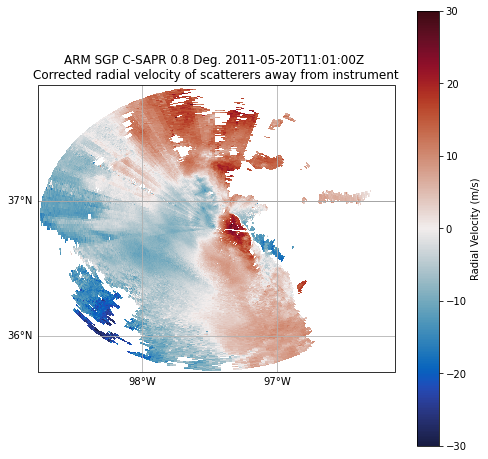

In [73]:
fig = plt.figure(figsize=[8, 8])
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map('corrected_velocity',
                     sweep=0,
                     resolution='50m',
                     vmin=-30,
                     vmax=30, 
                     projection=ccrs.PlateCarree(),
                     colorbar_label='Radial Velocity (m/s)',
                     cmap='pyart_balance',
                     gatefilter=gatefilter)
plt.show()

## Compare our Raw Velocity Field to our Dealiased, Cleaned Velocity Field
As a last comparison, let's compare our raw, uncorrected velocities with our cleaned velocities, after applying the velocity texture threshold and dealiasing algorithm

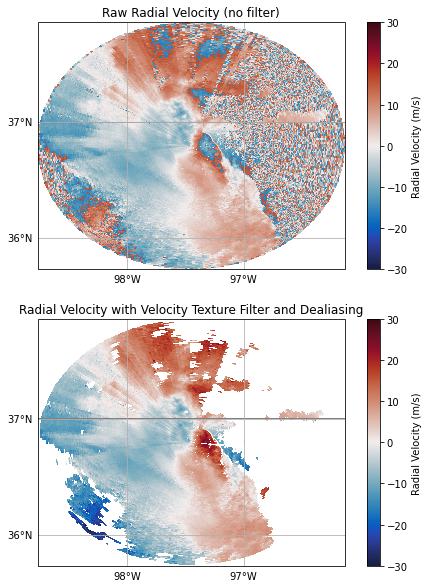

In [72]:
# Plot our Unfiltered Data
fig = plt.figure(figsize=[8, 10])
ax = plt.subplot(211, projection=ccrs.PlateCarree())
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map('velocity',
                     title='Raw Radial Velocity (no filter)',
                     ax=ax,
                     sweep=0,
                     resolution='50m',
                     vmin=-30,
                     vmax=30,
                     projection=ccrs.PlateCarree(),
                     colorbar_label='Radial Velocity (m/s)',
                     cmap='pyart_balance')

ax2 = plt.subplot(2,1,2,projection=ccrs.PlateCarree())

# Plot our filtered, dealiased data
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map('corrected_velocity',
                     title='Radial Velocity with Velocity Texture Filter and Dealiasing',
                     ax=ax2,
                     sweep=0,
                     resolution='50m',
                     vmin=-30,
                     vmax=30, 
                     projection=ccrs.PlateCarree(),
                     gatefilter=gatefilter,
                     colorbar_label='Radial Velocity (m/s)',
                     cmap='pyart_balance')
plt.show()

## Conclusions
Within this lesson, we walked through how to apply radial velocity corrections to a dataset, filtering based on the velocity texture and using a regional dealiasing algorithm.

### What's Next
In the next few notebooks, we walk through gridding radar data and advanced visualization methods!

## Resources and References
Py-ART essentials links:

* [Landing page](arm-doe.github.io/pyart/)
* [Examples](https://arm-doe.github.io/pyart/examples/index.html)
* [Source Code](github.com/ARM-DOE/pyart)
* [Mailing list](groups.google.com/group/pyart-users/)
* [Issue Tracker](github.com/ARM-DOE/pyart/issues)